In [1]:
# Installation Packages.
import pandas as pd 
import numpy as np
import skimpy
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt

import sklearn.preprocessing as pre
import sklearn.model_selection as ms 
import sklearn.linear_model as lm 
import sklearn.metrics as mt

In [2]:
import warnings 
warnings.filterwarnings("ignore")

In [4]:
# Importation de données.
df = pd.read_csv('../data/INNHotelsGroup.csv')
df = df.drop(columns='Booking_ID')

## Description des variables
- **Booking_ID** : unique identifier of each booking
- **no_of_adults** : Number of adults
- **no_of_children** : Number of Children
- **no_of_weekend_nights** : Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
- **no_of_week_nights** : Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
- **type_of_meal_plan** : Type of meal plan booked by the customer:
    - Not Selected – No meal plan selected
    - Meal Plan 1 – Breakfast
    - Meal Plan 2 – Half board (breakfast and one other meal)
    - Meal Plan 3 – Full board (breakfast, lunch, and dinner)
- **required_car_parking_space** : Does the customer require a car parking space? (0 - No, 1- Yes)
- **room_type_reserved** : Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.
- **lead_time** : Number of days between the date of booking and the arrival date
- **arrival_year** : Year of arrival date
- **arrival_month** : Month of arrival date
- **arrival_date** : Date of the month
- **market_segment_type** : Market segment designation.
- **repeated_guest** : Is the customer a repeated guest? (0 - No, 1- Yes)
- **no_of_previous_cancellations** : Number of previous bookings that were canceled by the customer prior to the current booking
- **no_of_previous_bookings_not_canceled** : Number of previous bookings not canceled by the customer prior to the current booking
- **avg_price_per_room** : Average price per day of the reservation; prices of the rooms are dynamic. (in euros)
- **no_of_special_requests** : Total number of special requests made by the customer (e.g. high floor, view from the room, etc)
- **booking_status** : Flag indicating if the booking was canceled or not.

## Informations de Base

In [5]:
# Affichage des premières lignes du dataset
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [6]:
# Dimensions du dataset 
df.shape

(36275, 18)

In [7]:
# Types de variables 
df.dtypes

no_of_adults                              int64
no_of_children                            int64
no_of_weekend_nights                      int64
no_of_week_nights                         int64
type_of_meal_plan                        object
required_car_parking_space                int64
room_type_reserved                       object
lead_time                                 int64
arrival_year                              int64
arrival_month                             int64
arrival_date                              int64
market_segment_type                      object
repeated_guest                            int64
no_of_previous_cancellations              int64
no_of_previous_bookings_not_canceled      int64
avg_price_per_room                      float64
no_of_special_requests                    int64
booking_status                           object
dtype: object

In [8]:
# Statistiques Descriptives
skimpy.skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 36275  │ │ int64       │ 13    │                                                          │
│ │ Number of columns │ 18     │ │ string      │ 4     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━━┓  │
│ ┃ column                  ┃ NA  ┃ NA %  ┃ mean     ┃ sd      ┃ p0    ┃ p25   ┃ p50    ┃ p75  ┃ p100 ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━━┩  │
│ │ no_of_adults            │   0 │     0 │    1.845 │  0.5187 │     0 │     2 │      2 │    2 │    4 │  ▂ █▁  │  │
│ │ no_of_children          │   0 │     0 │   0.1053 │  0.4026 │     0 │     0 │      0 │    0 │   10 │   █    │  │
│ │ no_of_weekend_nights    │   0 │     0 │   0.8107 │  0.8706 │     0 │     0 │      1 │    2 │    7 │   █▃   │  │
│ │ no_of_week_nights       │   0 │     0 │    2.204 │   1.411 │     0 │     1 │      2 │    3 │   17 │   █▄   │  │
│ │ required_car_parking_sp │   0 │     0 │  0.03099 │  0.1733 │     0 │     0 │      0 │    0 │    1 │   █    │  │
│ │ ace                     │     │       │          │         │       │       │        │      │      │        │  │
│ │ lead_time               │   0 │     0 │    85.23 │   85.93 │     0 │    17 │     57 │  126 │  443 │  █▃▂▁  │  │
│ │ arrival_year            │   0 │     0 │     2018 │  0.3838 │  2017 │  2018 │   2018 │ 2018 │ 2018 │ ▂    █ │  │
│ │ arrival_month           │   0 │     0 │    7.424 │    3.07 │     1 │     5 │      8 │   10 │   12 │ ▂▄▅▅█▅ │  │
│ │ arrival_date            │   0 │     0 │     15.6 │    8.74 │     1 │     8 │     16 │   23 │   31 │ ▇▇██▇█ │  │
│ │ repeated_guest          │   0 │     0 │  0.02564 │  0.1581 │     0 │     0 │      0 │    0 │    1 │   █    │  │
│ │ no_of_previous_cancella │   0 │     0 │  0.02335 │  0.3683 │     0 │     0 │      0 │    0 │   13 │   █    │  │
│ │ tions                   │     │       │          │         │       │       │        │      │      │        │  │
│ │ no_of_previous_bookings │   0 │     0 │   0.1534 │   1.754 │     0 │     0 │      0 │    0 │   58 │   █    │  │
│ │ _not_canceled           │     │       │          │         │       │       │        │      │      │        │  │
│ │ avg_price_per_room      │   0 │     0 │    103.4 │   35.09 │     0 │  80.3 │  99.45 │  120 │  540 │   ▅█   │  │
│ │ no_of_special_requests  │   0 │     0 │   0.6197 │  0.7862 │     0 │     0 │      0 │    1 │    5 │  █▅▂   │  │
│ └─────────────────────────┴─────┴───────┴──────────┴─────────┴───────┴───────┴────────┴──────┴──────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┓  │
│ ┃           ┃    ┃      ┃           ┃           ┃           ┃           ┃ chars per ┃ words per ┃ total      ┃  │
│ ┃ column    ┃ NA ┃ NA % ┃ shortest  ┃ longest   ┃ min 

## EDA

In [9]:
df_quant = df.select_dtypes(exclude='object')
df_qual = df.select_dtypes(include='object')

### Analyse univarié 

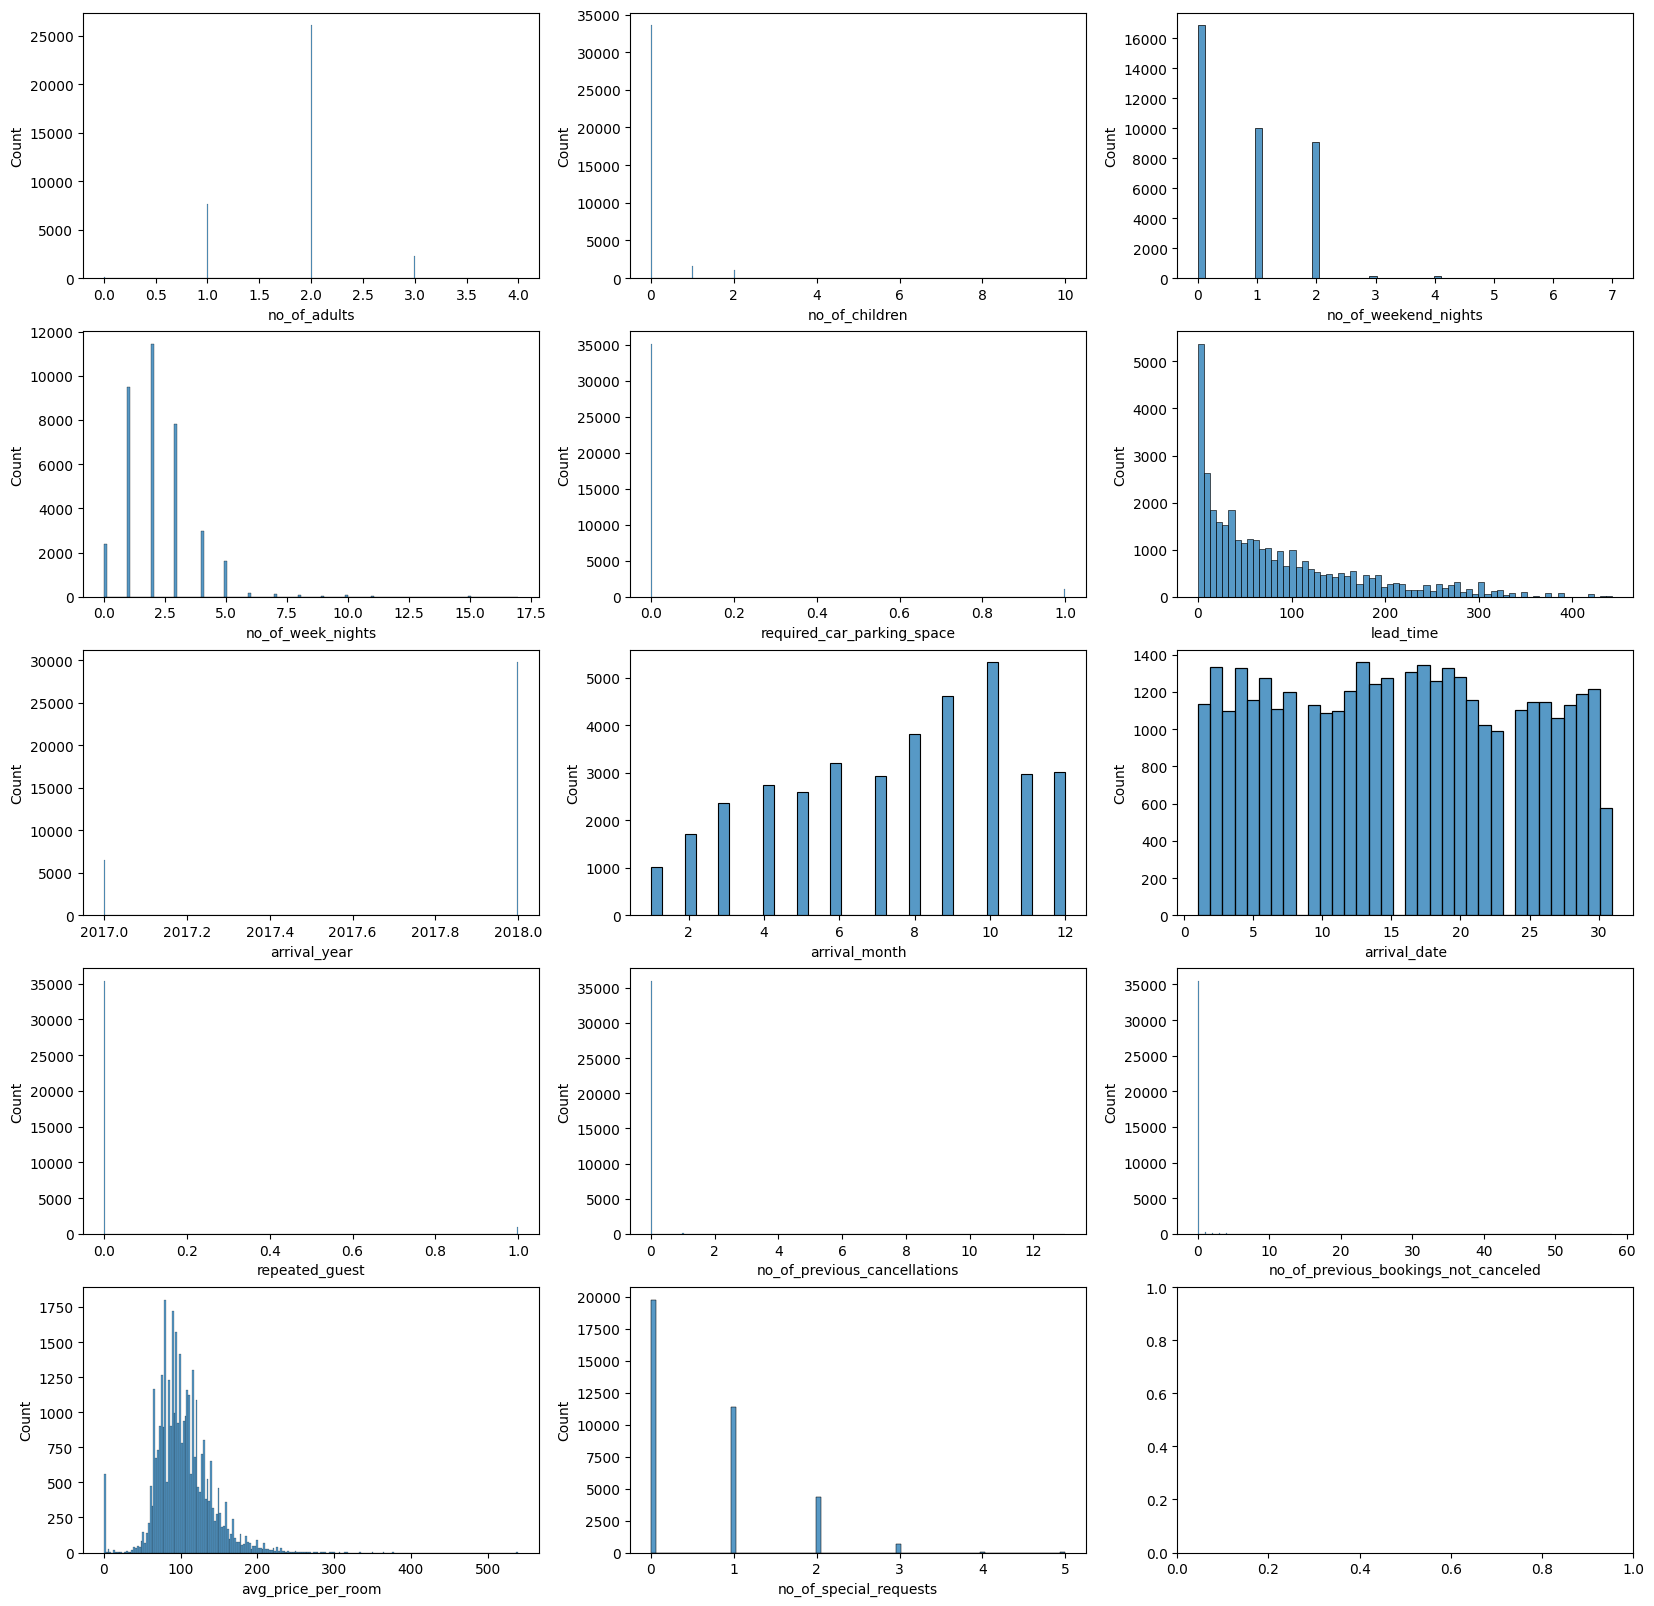

In [10]:
fig, ax = plt.subplots(5,3, figsize = (20,20))
for i, subplots in zip(df_quant.columns, ax.flatten()) :
    sns.histplot(df_quant[i], ax = subplots)
fig.show()

- **Anomalies** : Nous constatons certains comportements qui peuvent être suspects. Par exemple, le fait que certains prix moyens soient à 0.

Nous pouvons apercévoir que le prix sont en général entre 50 et 200. La plupart de gens prennent des réservation entre le jour même et 100 jours.\
Le nombre de nuits aussi est concentré entre 1 et 5 nuits. Il semblerait que la plupart de personnes viennent sans enfants et que peu des personnes\
sont des habitués aux hotels.  Cette dernière variable jointe à la demande de parking nous montrent leur caractère binaire qui sera pris en compte\
dans la suite de l'analyse. 

Quant aux annulations ce que nous pouvons en tirer ce que la plupart de repeated guests n'auraient pas fait une annulation mais nous devons encore\
approfondir un peu. 

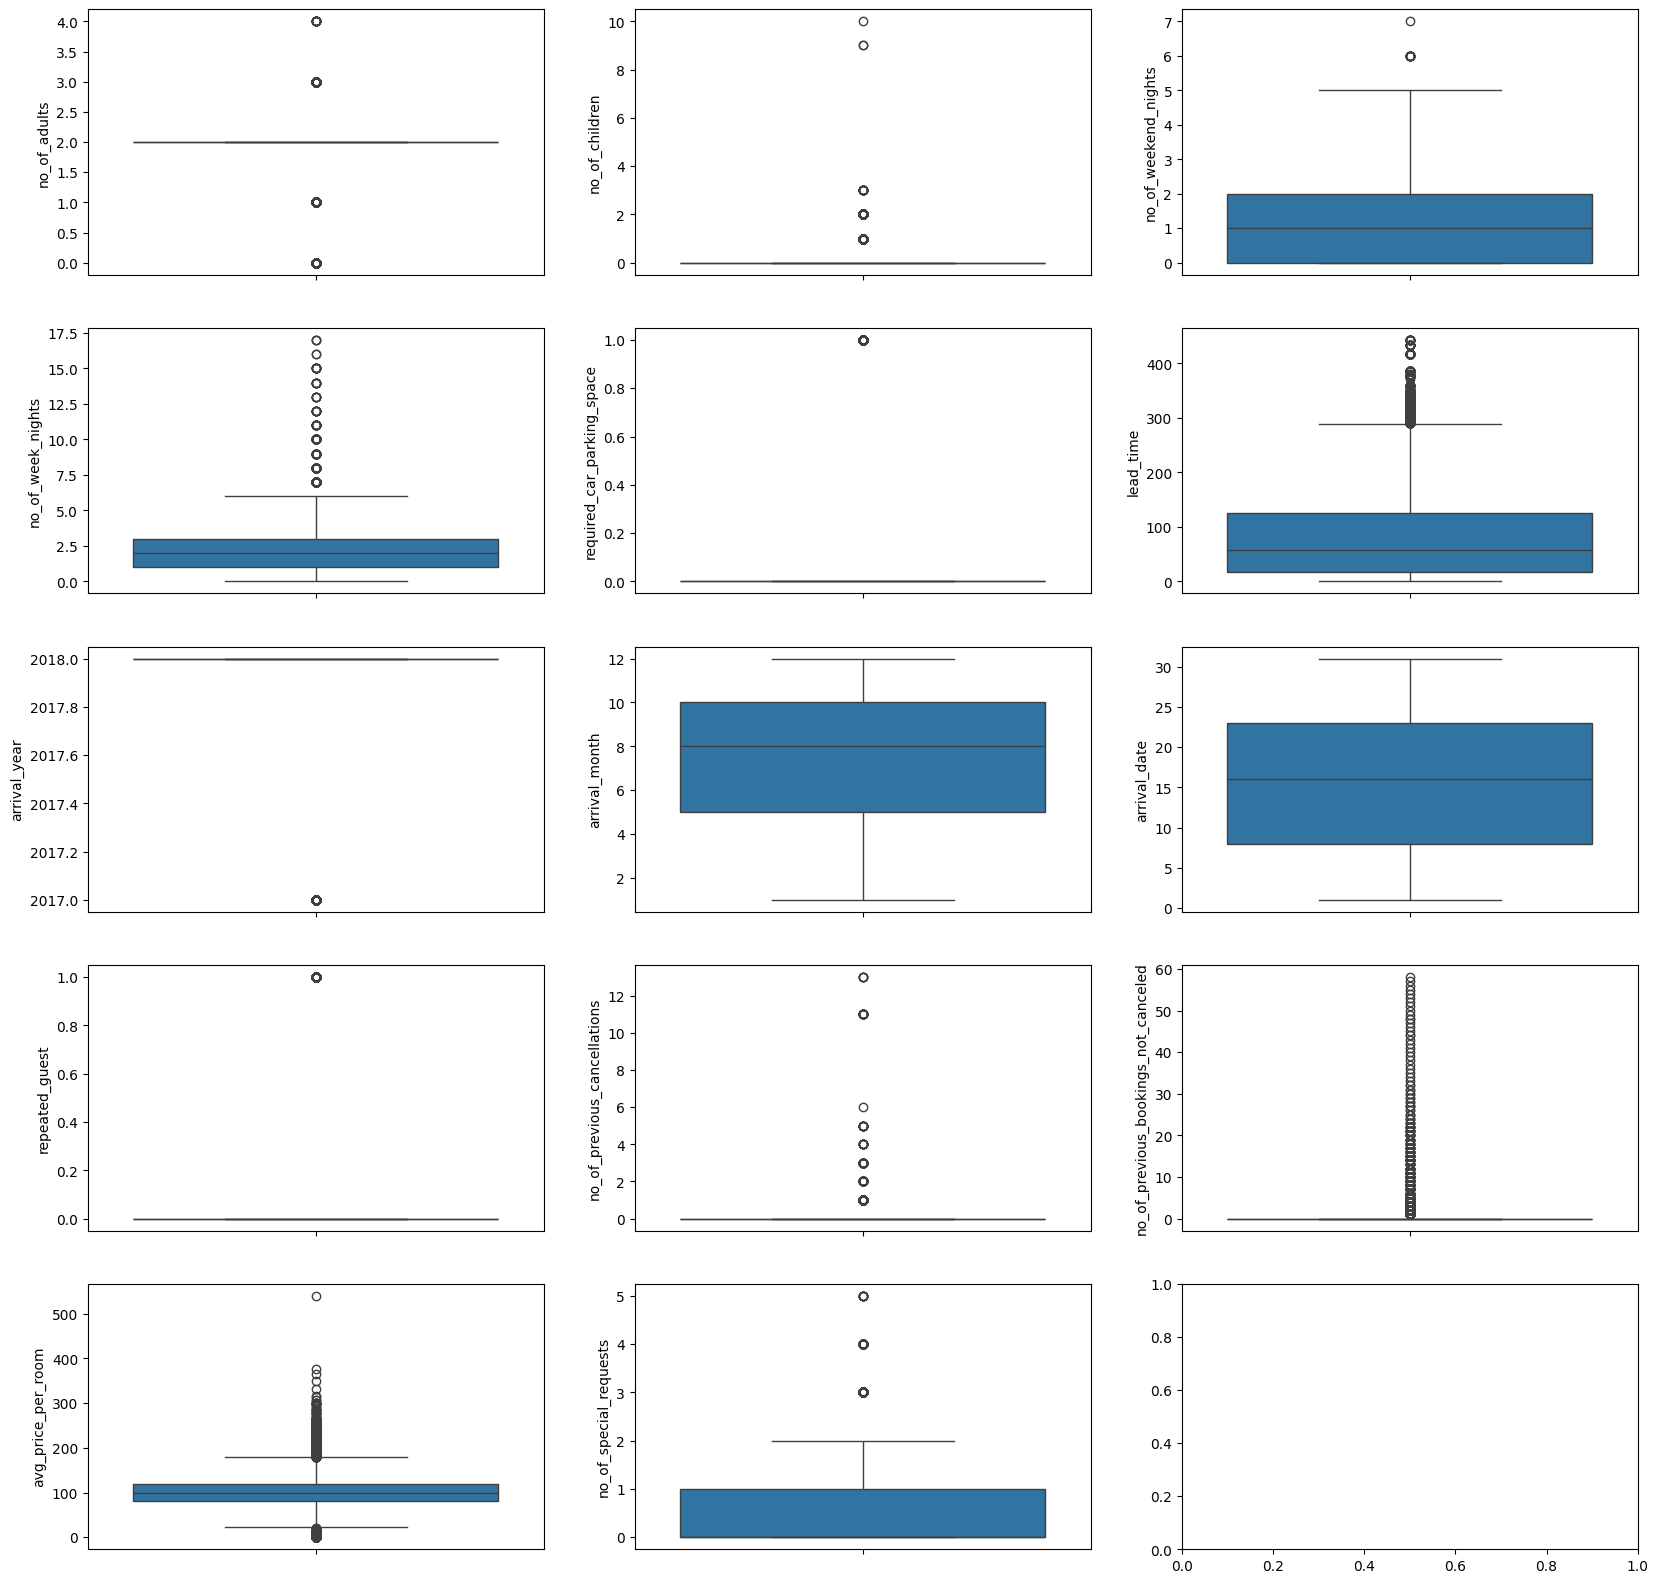

In [11]:
fig, ax = plt.subplots(5,3, figsize = (20,20))
for i, subplots in zip(df_quant.columns, ax.flatten()) :
    sns.boxplot(df_quant[i], ax = subplots)
fig.show()

Ici nous pouvons nous apercevoir de la présence de valeurs qui peuvent être considérées comme "aberrantes". Pour les variables binaires,\
il est normale d'avoir un outlier. De même, certaines valeurs élevées sont quant même plausibles. D'autres, moins. Il faudrait voir la\
nature de ces points et voir si un traitement est pertinent. 

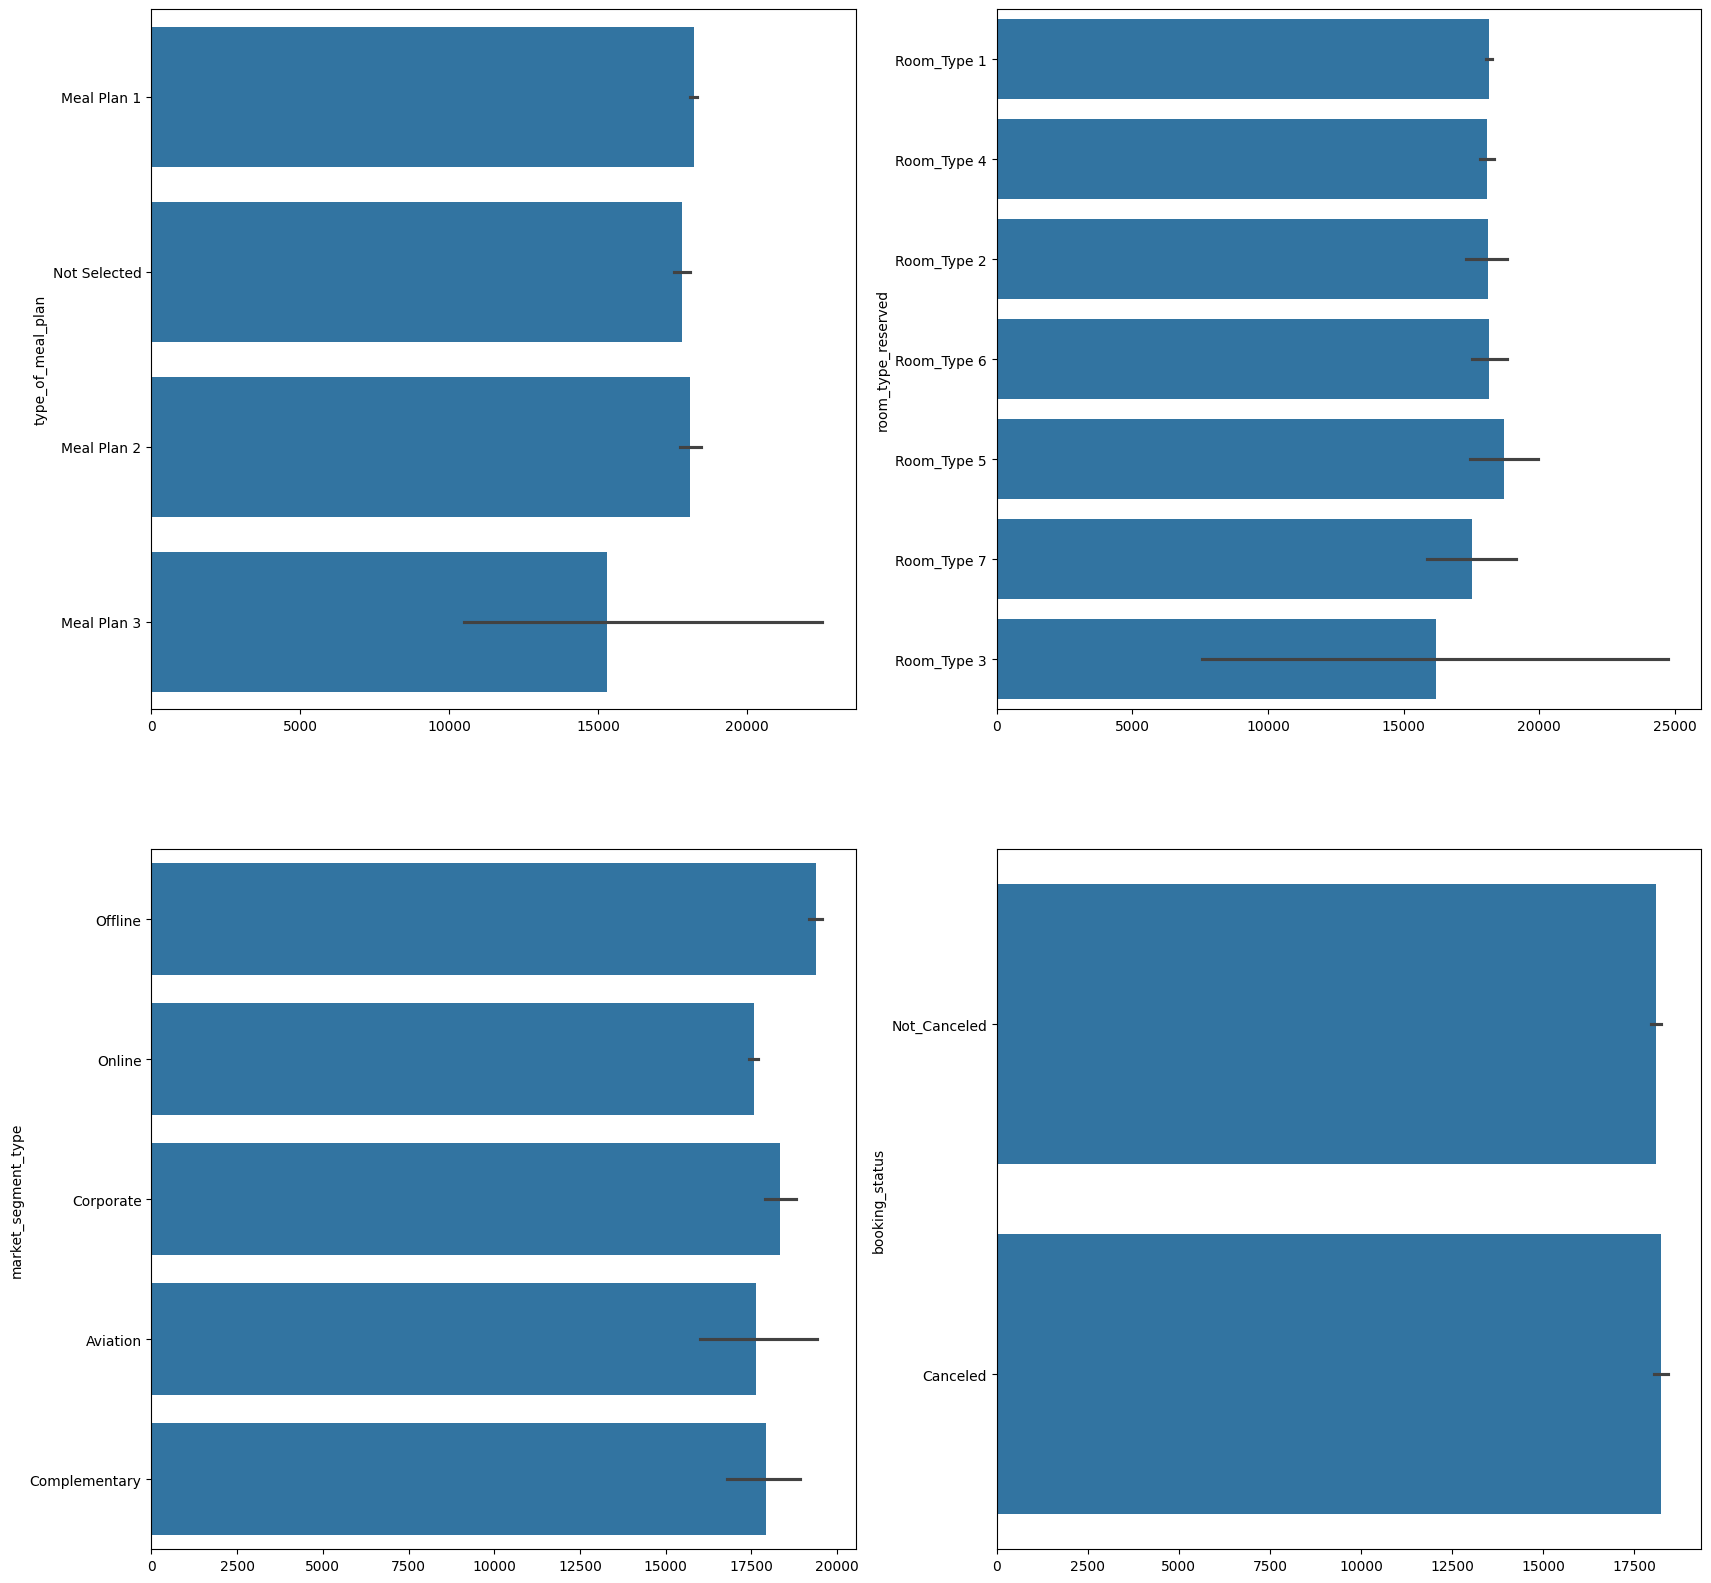

In [12]:
fig, ax = plt.subplots(2,2, figsize = (20,20))
for i, subplots in zip(df_qual.columns, ax.flatten()) :
    sns.barplot(df_qual[i], ax = subplots)
fig.show()

Ici nous voyons les fréquences des valeurs uniques dans les vairables qualitatives. Une repartition assez uniforme paraît avoir lieu\
dans toutes les variables. Nous voyons qu'il semblerait qu'il y a autant de reservations qui sont cancellées que celles qui ont\
finalement lieu. Lorsque nous parlons des variables telles que type de room et type de petit déjeuner, nous pouvons nous rendre compte\
qu'un type a un grand écart-type. 

### Analyse bivarié
* Nous prenons comme variable cible le statut de la reservation. 

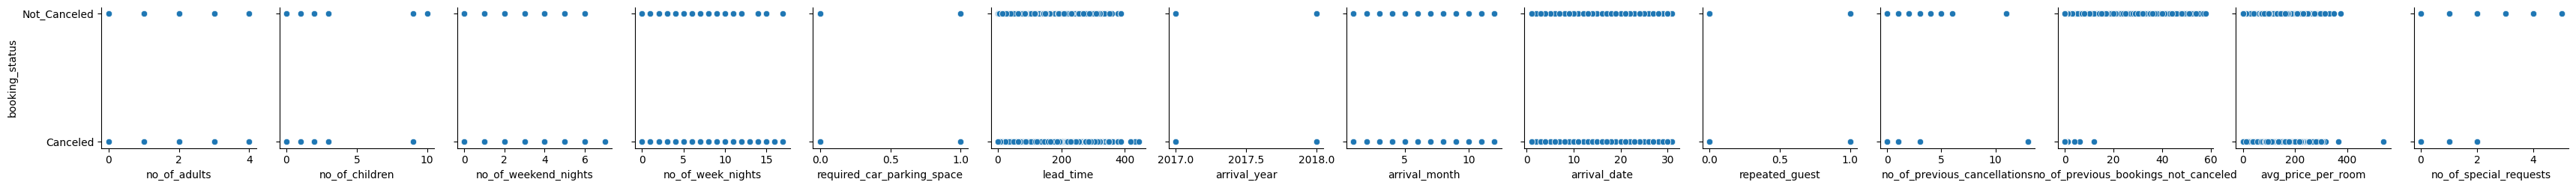

In [13]:
plt.Figure(figsize=(10,5))
sns.pairplot(df, x_vars=  df_quant.columns, y_vars= "booking_status")
plt.show()

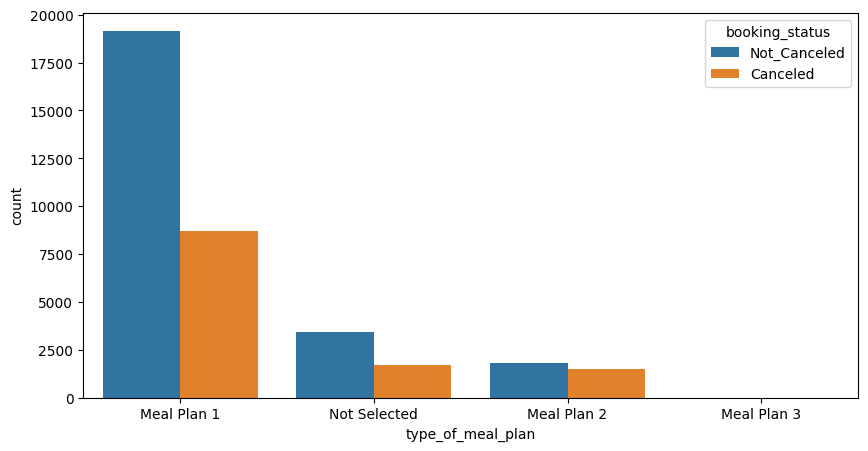

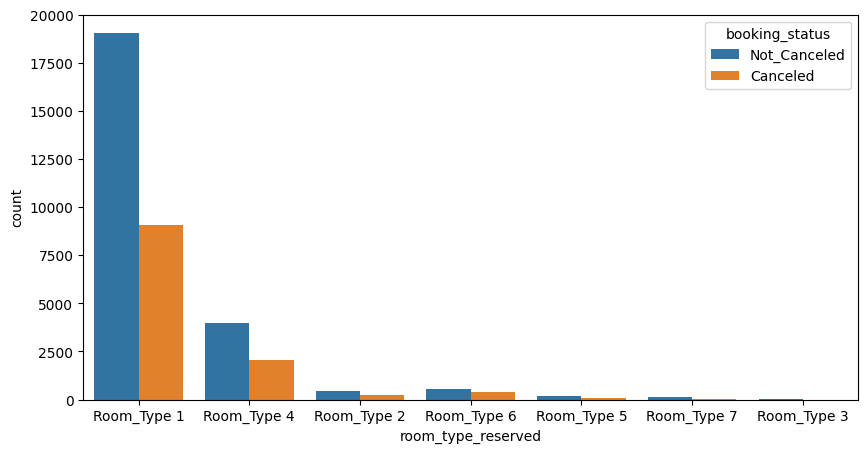

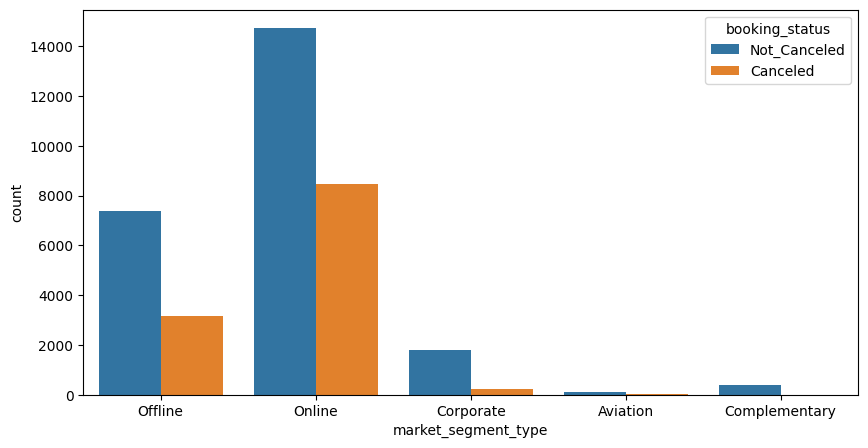

In [14]:
for i in range(len(df_qual.columns)-1):
    plt.figure(figsize=(10,5))
    sns.countplot(df_qual, x= df_qual.columns[i] , hue = 'booking_status')
    plt.show()

### Analyse multivarié

In [15]:
df_quant_corr = df_quant.corr()

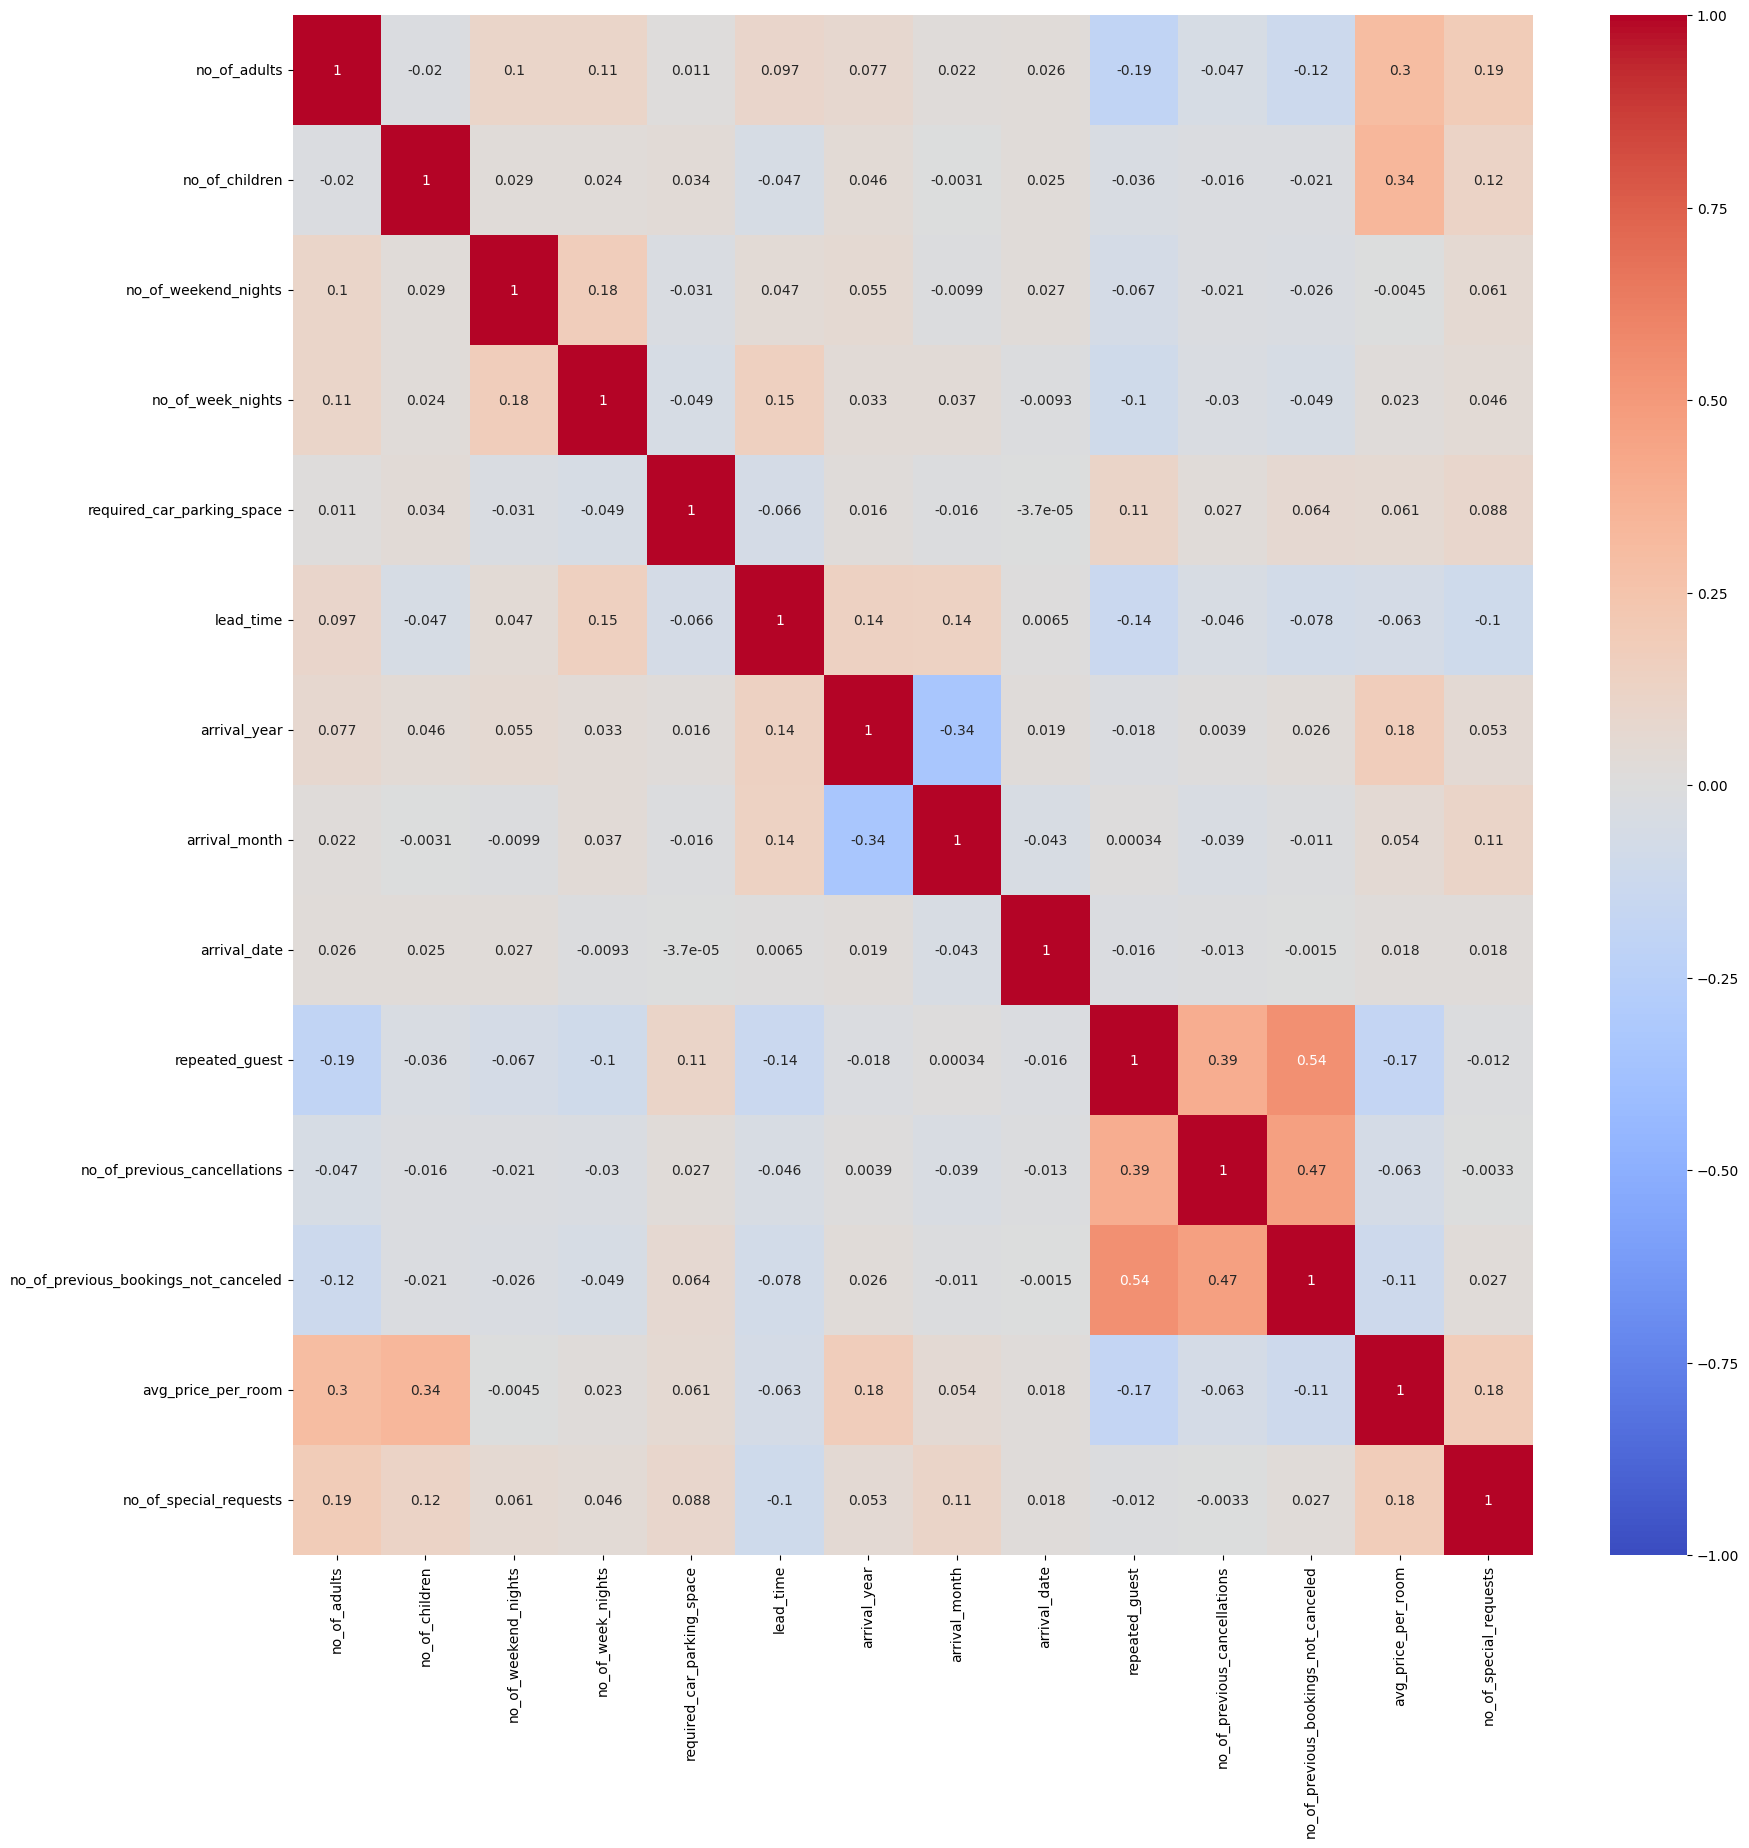

In [16]:
plt.figure(figsize=(20,20))
sns.heatmap(df_quant_corr, vmin= -1, vmax =1, annot= True, cmap='coolwarm')
plt.show()

Les variables quantitatives semblent peu corrélées. Il est important de tenir\
compte que certaines de ces variables sont à coder d'une façon ou une autre.\
Ainsi, pas tout est interpretable d'un premier point de vue.\
De plus, il se peut qu'on ait des rélations non linéaires. Cependant, ce que\
l'on peut dire c'est que du fait que ces corrélations sont faibles, il semble-\
rait qu'on ait pas de colinéarité.

### Split Train Test

In [17]:
Y = df['booking_status']
X = df.drop(columns='booking_status')

In [18]:
X_train, X_test, Y_train, Y_test = ms.train_test_split(X,Y, test_size= 0.2, train_size= 0.8, random_state= 16)

### Encodage des variables qualitatives

In [19]:
# Colonnes pertinentes pour One Hot Encoding.
X_enc_variables = X.select_dtypes(include='object').columns

# N.b. On a pas enlévé une modalité pour l'instant. 

In [20]:
# Entrainement et preparation à partir de l'echantillon train.
encoder = pre.OneHotEncoder(sparse_output=False, drop = 'first')
encoder.fit(X_train[X_enc_variables])


,categories,'auto'
,drop,'first'
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'error'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [21]:
# Transformation de l'echantillon train. 
X_train_encoded = encoder.transform(X_train[X_enc_variables])
X_train_encoded = pd.DataFrame(X_train_encoded,columns=encoder.get_feature_names_out(X_enc_variables))
X_train_encoded.index = X_train.index
X_train_encoded.head()


,type_of_meal_plan_Meal Plan 2,type_of_meal_plan_Meal Plan 3,type_of_meal_plan_Not Selected,room_type_reserved_Room_Type 2,room_type_reserved_Room_Type 3,room_type_reserved_Room_Type 4,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,room_type_reserved_Room_Type 7,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Offline,market_segment_type_Online
730,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21086,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
23484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
30094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [22]:
X_train_encoded.head()

,type_of_meal_plan_Meal Plan 2,type_of_meal_plan_Meal Plan 3,type_of_meal_plan_Not Selected,room_type_reserved_Room_Type 2,room_type_reserved_Room_Type 3,room_type_reserved_Room_Type 4,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,room_type_reserved_Room_Type 7,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Offline,market_segment_type_Online
730,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21086,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
23484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
30094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [23]:
# Transformation de l'echantillon test.
X_test_encoded = encoder.transform(X_test[X_enc_variables])
X_test_encoded = pd.DataFrame(X_test_encoded,columns=encoder.get_feature_names_out(X_enc_variables))
X_test_encoded.index = X_test.index
X_test_encoded.head()

,type_of_meal_plan_Meal Plan 2,type_of_meal_plan_Meal Plan 3,type_of_meal_plan_Not Selected,room_type_reserved_Room_Type 2,room_type_reserved_Room_Type 3,room_type_reserved_Room_Type 4,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,room_type_reserved_Room_Type 7,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Offline,market_segment_type_Online
12174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
32923,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22503,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11674,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
# Transformation des label en une variable binaire quantitative. - Methode Ema 
Y_train_encoded_bis = np.where(Y_train == 'Not_Canceled', 0,1)
Y_test_encoded_bis = np.where(Y_test == 'Not_Canceled', 0,1)

### Pertinence des variables

Analyse statistiques du lien entre les variables et la variable cible
Pour les variables catégorielles, utilisation d'un test du Chi2.

Hypothèse H0 : Les variables sont indépendantes\
Hypothèse H1 : Les variables ne sont pas indépendantes

Si la valeur de la pvalue est inférieure à 5% on rejette l'hypothèse H0 avec un risque de 5%. On considère que les deux ne variables ne sont pas indépendantes

In [25]:
# Test de Chi 2 
for i in df_qual.columns: 
    if i != 'booking_status': 
        pivot = pd.crosstab(df[i],df['booking_status'])
        test_indep_quali = sp.stats.chi2_contingency(pivot)
        print(f'Entre {i} et Booking Status on a une statistique de {test_indep_quali.statistic} avec p-value {round(test_indep_quali.pvalue,200)}')

Entre type_of_meal_plan et Booking Status on a une statistique de 278.29490920586017 avec p-value 4.9519154060877897e-60
Entre room_type_reserved et Booking Status on a une statistique de 57.33495179790707 avec p-value 1.5627796772447482e-10
Entre market_segment_type et Booking Status on a une statistique de 814.108865240557 avec p-value 6.748763024557236e-175


Pour les variables quantitatives, utilisation d'un test du Student.

Hypothèse H0 : La distribution de la variable quantitative sachant target = 1 est la même que la distribution de la variable quantitative sachant target = 0\
Hypothèse H1 : Les distributions sont différentes

Si la valeur de la p-value est inférieure à 5% on rejette l'hypothèse H0 avec un risque de 5%. On considère que les distributions ne sont pas identiques

In [26]:
# Test de Student
for i in df_quant.columns:
    if i != 'booking_status': 
        a = list(df[df['booking_status']=='Not_Canceled'][i])
        b = list(df[df['booking_status']=='Canceled'][i])
        st_test, st_p = sp.stats.ttest_ind(a,b,axis = 0, equal_var=False)
        print(i + ": p-value test Student = " + str(st_p))

no_of_adults: p-value test Student = 2.125195840461949e-65
no_of_children: p-value test Student = 1.9746021531473454e-09
no_of_weekend_nights: p-value test Student = 4.838631407811381e-30
no_of_week_nights: p-value test Student = 5.450111353334159e-62
required_car_parking_space: p-value test Student = 3.368068076687889e-92
lead_time: p-value test Student = 0.0
arrival_year: p-value test Student = 0.0
arrival_month: p-value test Student = 0.021879873347925648
arrival_date: p-value test Student = 0.043471227593661385
repeated_guest: p-value test Student = 9.739644968354598e-178
no_of_previous_cancellations: p-value test Student = 2.3238269828901563e-14
no_of_previous_bookings_not_canceled: p-value test Student = 3.867328299826672e-60
avg_price_per_room: p-value test Student = 2.3570548204656775e-175
no_of_special_requests: p-value test Student = 0.0


### Matrice de correlation (One Hot Encoding Inclus)

In [27]:
# Fonction de création df avec encodage réalisé. 
def dfEncoded(data, dataEncoded, colEncoded): 
    encData = data.drop(columns = colEncoded)
    encData = encData.merge(dataEncoded,left_index = True, right_index = True)
    return encData

In [28]:
# Matrice complète Train.
X_train_v2 = dfEncoded(X_train, X_train_encoded, X_enc_variables)

In [29]:
X_train_v2

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,...,room_type_reserved_Room_Type 2,room_type_reserved_Room_Type 3,room_type_reserved_Room_Type 4,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,room_type_reserved_Room_Type 7,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Offline,market_segment_type_Online
730,2,0,0,4,0,152,2018,11,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2122,2,0,1,2,1,43,2018,2,26,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21086,2,0,1,4,0,51,2018,11,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
23484,2,0,2,2,0,35,2018,5,22,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
30094,2,0,0,4,0,120,2018,7,20,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21984,1,0,0,1,0,47,2018,4,12,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16765,2,0,1,3,0,85,2018,10,6,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
33403,2,2,2,3,0,125,2018,12,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
33349,1,0,0,2,0,6,2017,12,10,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [30]:
# Matrice complète Test.
X_test_v2 = dfEncoded(X_test, X_test_encoded, X_enc_variables)

In [31]:
X_test_v2

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,...,room_type_reserved_Room_Type 2,room_type_reserved_Room_Type 3,room_type_reserved_Room_Type 4,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,room_type_reserved_Room_Type 7,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Offline,market_segment_type_Online
12174,1,0,0,1,0,36,2017,10,17,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
32923,2,0,1,5,0,1,2018,6,27,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22503,2,0,1,3,0,20,2018,12,22,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11674,1,0,2,1,0,125,2018,8,7,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10521,1,0,0,3,0,37,2018,10,13,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15929,2,2,0,4,0,21,2018,6,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
12663,2,0,0,4,0,0,2018,11,16,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
238,2,0,2,2,0,35,2018,12,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4360,1,0,0,1,0,53,2018,10,14,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


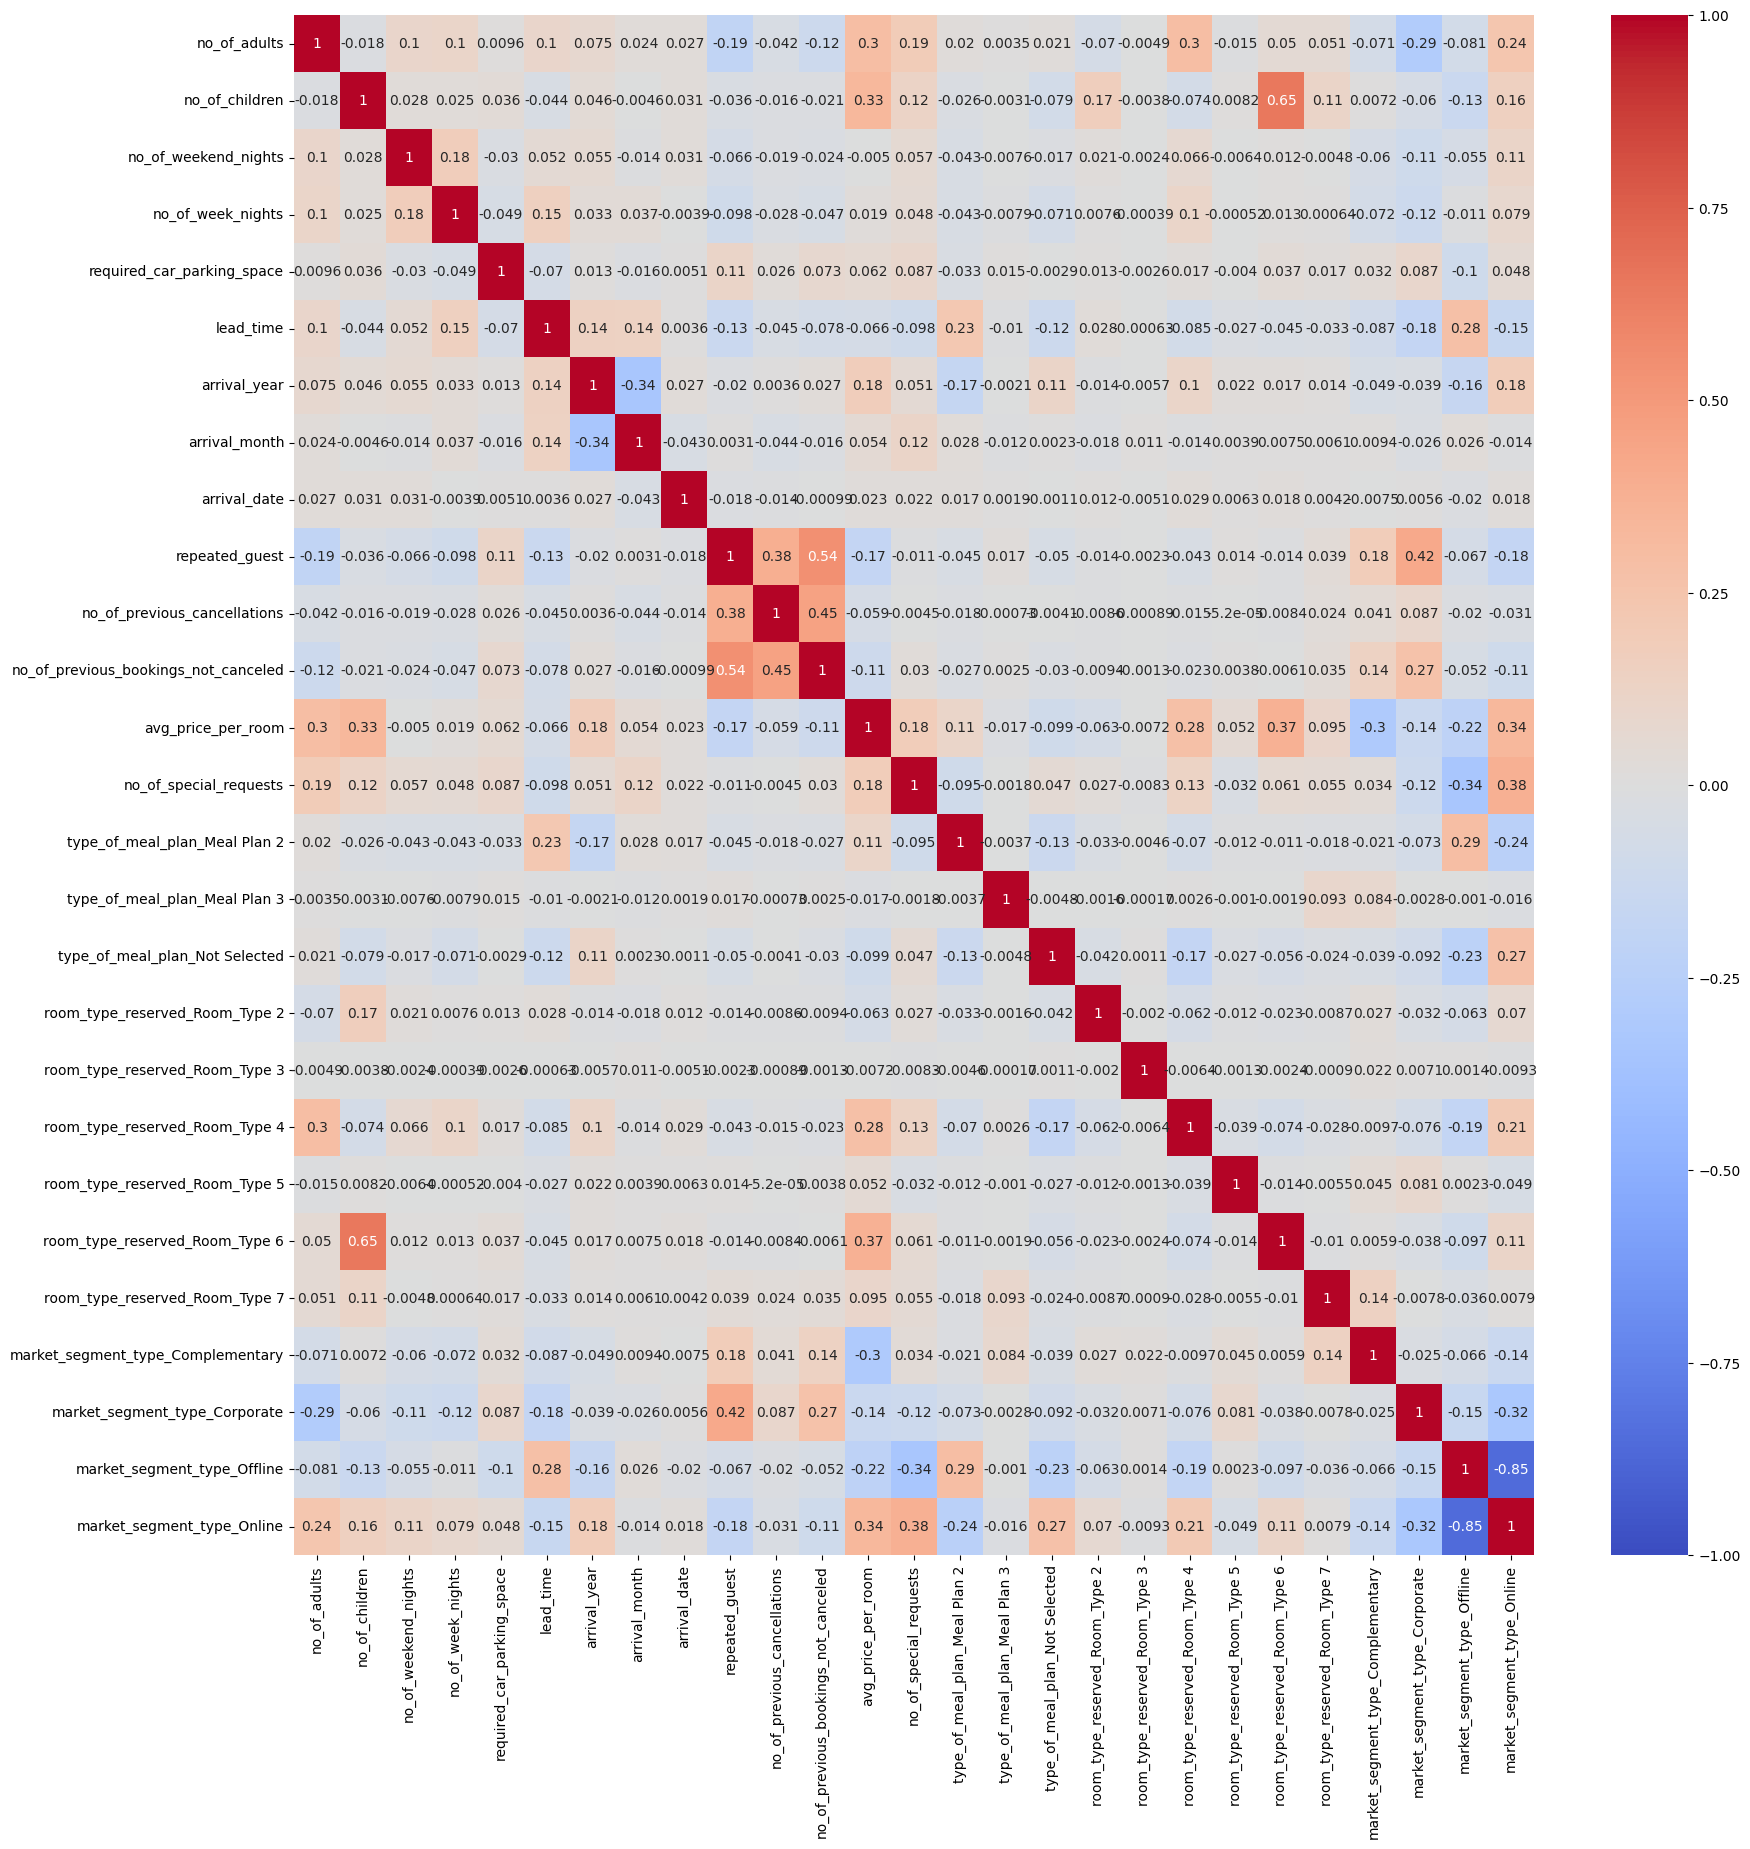

In [32]:
# Matrice de correlation de matrice complète Train. 
plt.figure(figsize=(20,20))
sns.heatmap(X_train_v2.corr(), vmin= -1, vmax =1, annot= True, cmap='coolwarm')
plt.show()

### Lasso Selection de variables

In [33]:
# Preparation des données pour Lasso.
Y_train_np = np.array(Y_train_encoded_bis)
X_train_np = X_train_v2.astype(float).to_numpy()

In [34]:
# Mise en place de Lars Path à la Lasso.
lasso_alpha, lasso_active ,lasso_coef = lm.lars_path(X_train_np, Y_train_np, method ='lasso')

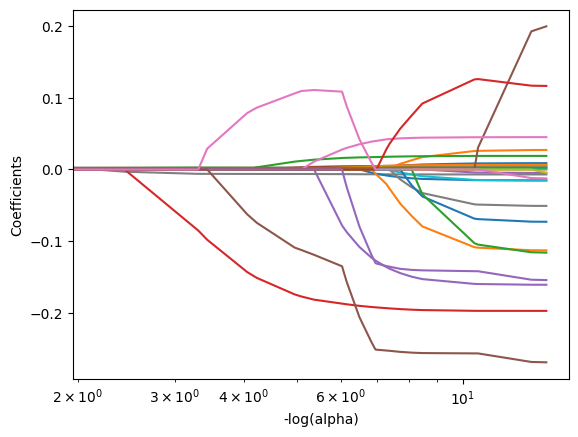

In [35]:
# Graphique des coefficients en fonction d'alpha. 
plt.plot(-np.log(lasso_alpha),np.transpose(lasso_coef))
plt.xlabel("-log(alpha)")
plt.ylabel("Coefficients")
plt.xscale('log')
plt.show()

In [36]:
# Calcul MSE d'après plusieurs alpha.
alphas = np.logspace(-2,2,10)
mse_lasso = []
for i in alphas :
    mod_lasso = lm.Lasso(alpha =i)
    mod_lasso.fit(X_train_np,Y_train_np)   
    Y_pred_lasso = mod_lasso.predict(X_test_v2) 
    mse_lasso.append(mt.mean_squared_error(Y_test_encoded_bis, Y_pred_lasso))

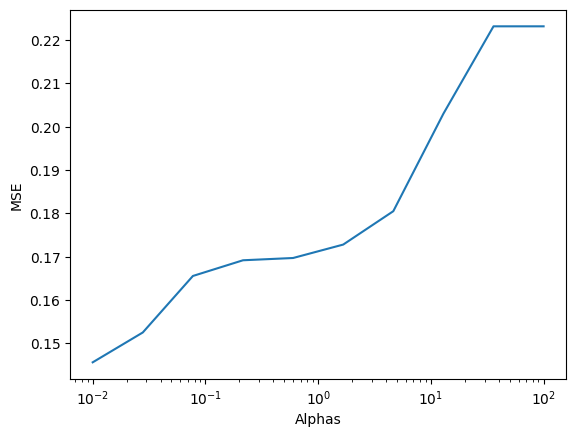

In [37]:
# Graphique evolution MSE en fonction de Alpha.
plt.Figure(figsize=(10,5))
plt.plot(alphas, mse_lasso)
plt.xlabel("Alphas")
plt.ylabel("MSE")
plt.xscale('log')
plt.show()

In [38]:
# Cross Validation Lasso pour trouver l'Alpha et la MSE optimale. 
mod_lasso_cv = lm.LassoCV(cv = 5)
mod_lasso_cv.fit(X_train_np,Y_train_encoded_bis)
lasso_alpha_opt = mod_lasso_cv.alpha_
print(f"L'alpha optimal correspond à {lasso_alpha_opt}")

Y_pred_lasso_CV = mod_lasso_cv.predict(X_test_v2)
mse_lasso_CV = mt.mean_squared_error(Y_test_encoded_bis, Y_pred_lasso_CV)
print(f"La MSE correspondant à l'alpha décrit ci-dessus est {mse_lasso_CV}")

L'alpha optimal correspond à 0.017417960685399126
La MSE correspondant à l'alpha décrit ci-dessus est 0.14781696415378587


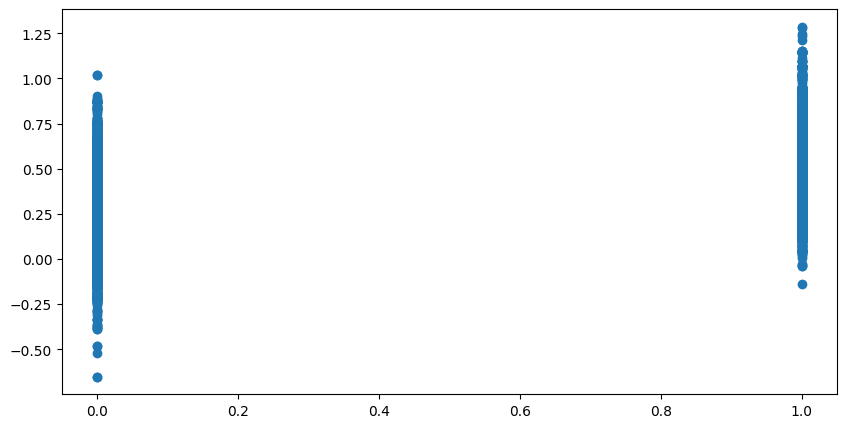

In [39]:
# Graphique entre valeurs predites et observées. 
plt.figure(figsize=(10,5))
plt.scatter(Y_test_encoded_bis, Y_pred_lasso_CV)
plt.show()

In [40]:
# Variables qui sont significatives selon le modèle Lasso CV. 
mod_lasso_cv.coef_

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.00248514,  0.        , -0.00621075,  0.        , -0.        ,
       -0.        ,  0.        ,  0.0023433 , -0.14234726, -0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
       -0.06152355,  0.07816514])

### Modelisation

In [41]:
# Dataset avec variables choisies. 
X_train_reduce_rl = X_train_v2.iloc[:,mod_lasso_cv.coef_ != 0]
X_test_reduce_rl = X_test_v2.iloc[:,mod_lasso_cv.coef_ != 0]

In [42]:
# Mise en place de la regression logistique. 
logistic_model = lm.LogisticRegression(fit_intercept=True)
logistic_model.fit(X_train_reduce_rl, Y_train_encoded_bis)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [43]:
# Prediction et evaluation au sense de la MSE.
Y_pred_rl = logistic_model.predict(X_test_reduce_rl)
mt.mean_squared_error(Y_test_encoded_bis,Y_pred_rl)

0.1994486560992419

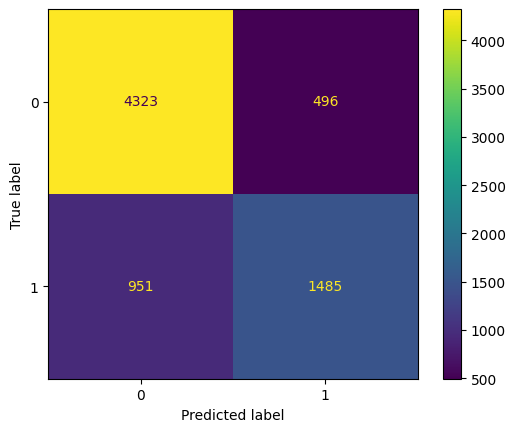

In [44]:
# Evaluation au sens de la matrice de confusion. 
rl_confMatrix = mt.confusion_matrix(Y_test_encoded_bis,Y_pred_rl)
cmPlot = mt.ConfusionMatrixDisplay(rl_confMatrix)
cmPlot.plot()

In [45]:
# Evaluation au sens du F1 Score. 
mt.f1_score(Y_test_encoded_bis,Y_pred_rl)

0.6724020828616708